## **Setup**

In [3]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# XGBOOST
import xgboost as xgb
from xgboost import XGBClassifier

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data
from scipy.stats import sem
from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline

import logging

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [16]:
# Extend NLTK stopwords with additional terms relevant to financial sentiment analysis
stop_words_extended = stopwords.words('english') + ['rt', 'ep']

# Reading the stored data
df = pd.read_feather("../Data/Full_Data.feather")

# Extracting features and labels
X = df['text']
Y = df['sentiment']

# Define custom stop words
custom_stopwords = stopwords.words('english') + ['rt', 'ep']

In [17]:
# label encodinhg ytrain for xgboost
le =LabelEncoder()
y = le.fit_transform(Y)

## **Vectorizers**

### Bag-Of-Words (BoW)

In [38]:
vectorizer = CountVectorizer(stop_words=stop_words_extended)
X_bow = vectorizer.fit_transform(X)

### Term Frequency-Inverse Document Frequency (TF-IDF)

In [39]:
vectorizer = TfidfVectorizer(stop_words=stop_words_extended)
X_tfidf = vectorizer.fit_transform(X)

## Train-Test Split

In [40]:
# Map the sentiment labels from [-1, 0, 1] to [0, 1, 2]
label_mapping = {-1: 0, 0: 1, 1: 2}
Y_mapped = Y.map(label_mapping)

X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bow, Y_mapped, test_size=0.2, random_state=40)
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, Y_mapped, test_size=0.2, random_state=40)

## **Model Training**

### Bag-Of-Words (BoW)

In [55]:
# Create an XGBoost classifier
xgb_model = XGBClassifier(n_estimators=3000, random_state=40)

# Train the model using the BoW vectorized data
xgb_model.fit(X_train_bow, y_train_bow)

# Predict the labels for the test data
y_pred = xgb_model.predict(X_test_bow)

# Calculate the accuracy
accuracy = accuracy_score(y_test_bow, y_pred)
print("Accuracy:", accuracy, "\n")

# Generate the classification report
report = classification_report(y_test_bow, y_pred)
print("Classification Report:")
print(report, "\n")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_bow, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9094302065190346 

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.72      0.75       898
           1       0.92      0.95      0.93      4666
           2       0.93      0.91      0.92      2474

    accuracy                           0.91      8038
   macro avg       0.88      0.86      0.87      8038
weighted avg       0.91      0.91      0.91      8038
 

Confusion Matrix:
[[ 645  198   55]
 [ 131 4424  111]
 [  47  186 2241]]


### Term Frequency-Inverse Document Frequency (TF-IDF)

In [56]:
# Create an XGBoost classifier
xgb_model = XGBClassifier(n_estimators=3000, random_state=40)

# Train the model using the BoW vectorized data
xgb_model.fit(X_train_bow, y_train_tfidf)

# Predict the labels for the test data
y_pred = xgb_model.predict(X_test_tfidf)

# Calculate the accuracy
accuracy = accuracy_score(y_test_tfidf, y_pred)
print("Accuracy:", accuracy, "\n")

# Generate the classification report
report = classification_report(y_test_tfidf, y_pred)
print("Classification Report:")
print(report, "\n")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_tfidf, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9002239363025628 

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.67      0.73       898
           1       0.90      0.95      0.93      4666
           2       0.92      0.89      0.91      2474

    accuracy                           0.90      8038
   macro avg       0.88      0.84      0.85      8038
weighted avg       0.90      0.90      0.90      8038
 

Confusion Matrix:
[[ 602  242   54]
 [ 110 4427  129]
 [  43  224 2207]]


## **Repeated K-Fold Cross Validation**

In [18]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_extended, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X)

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text])

In [19]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X)

X_bow_combined = hstack([X_bow_text])

In [20]:
# evaluate a model with a given number of repeats
def evaluate_model(X, y, repeats):
	# prepare the cross-validation procedure
    xg =  XGBClassifier(n_estimators=3000, random_state=40, learning_rate = 0.3, max_depth = 3)
    # prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=repeats, random_state=1)
    # evaluate model
    scores = cross_val_score(xg, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

>1 mean=0.85362514 se=0.002
>2 mean=0.85234280 se=0.002
>3 mean=0.85207959 se=0.001
>4 mean=0.85246582 se=0.001
>5 mean=0.85234648 se=0.001
>6 mean=0.85219669 se=0.001
>7 mean=0.85210463 se=0.001
>8 mean=0.85207076 se=0.001
>9 mean=0.85206397 se=0.001


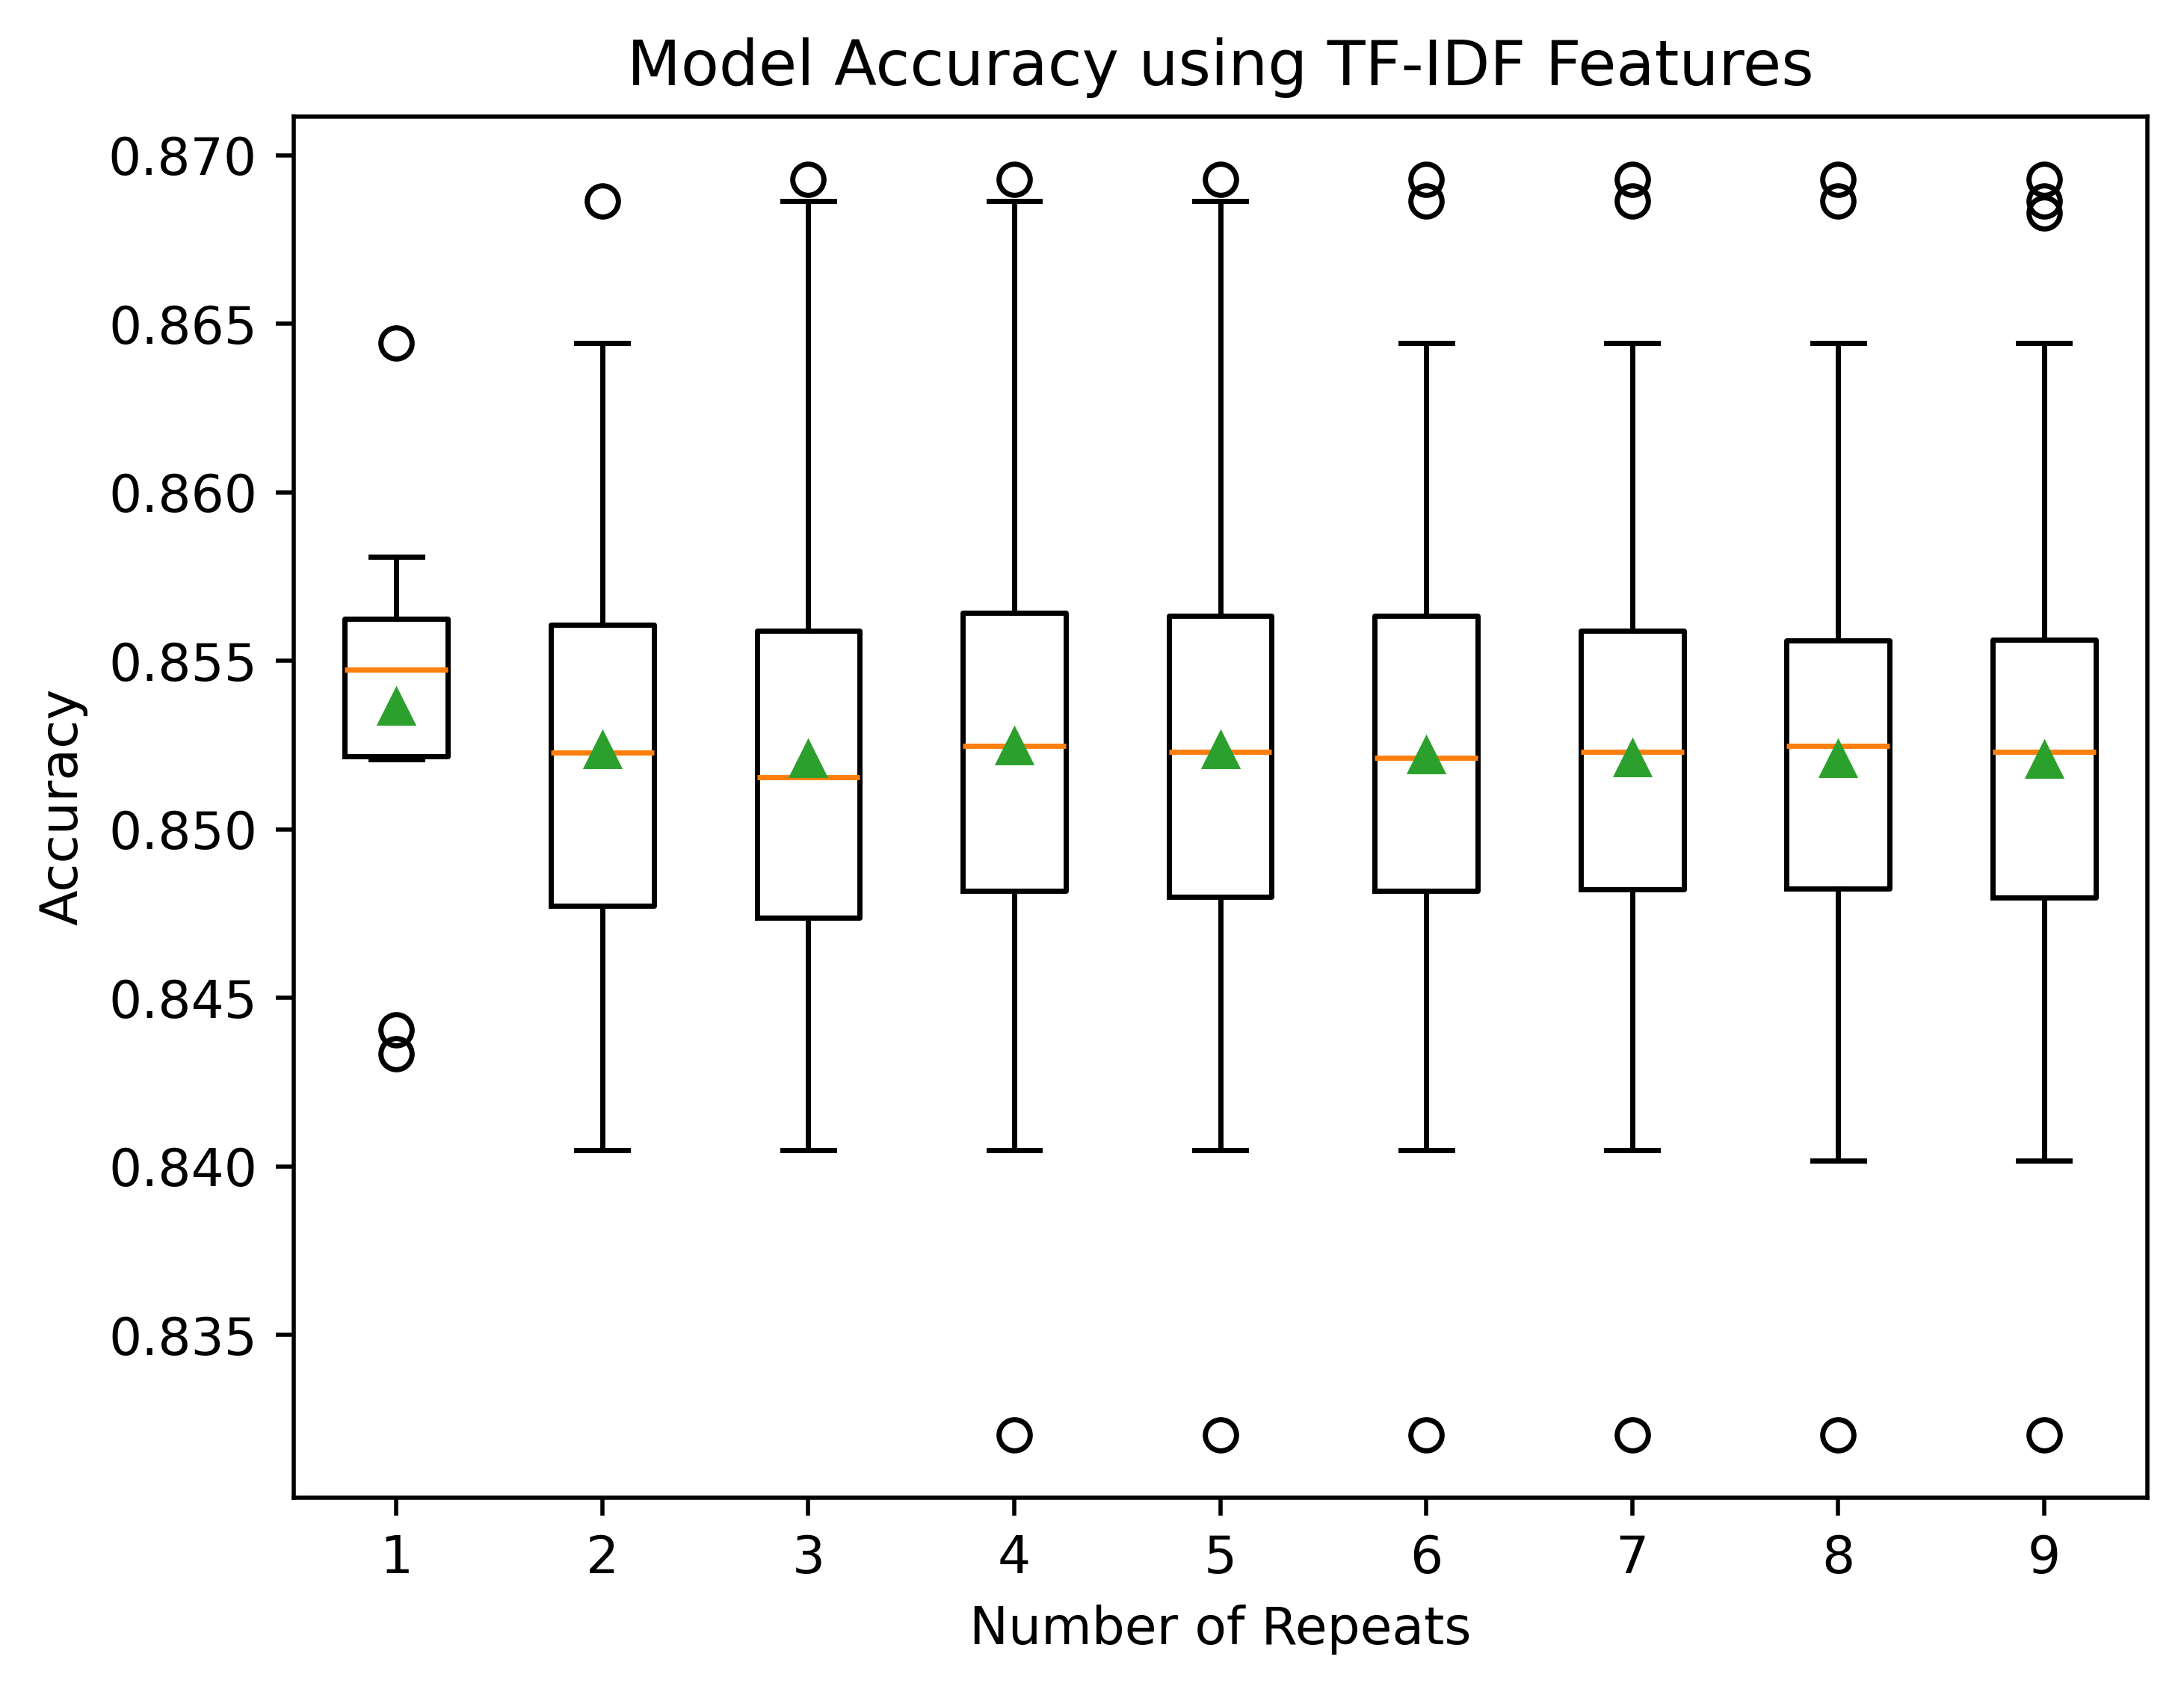

In [21]:
repeats = range(1,10)

results = list()
for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_tfidf_combined, y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "xgb_tfidf"
dataset = "Full"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/{dataset}/{model}.csv', index=False)

>1 mean=0.86001828 se=0.002
>2 mean=0.85966666 se=0.001
>3 mean=0.85965518 se=0.001
>4 mean=0.85950000 se=0.001
>5 mean=0.85944917 se=0.001
>6 mean=0.85933329 se=0.001
>7 mean=0.85929057 se=0.001
>8 mean=0.85919715 se=0.001
>9 mean=0.85913225 se=0.001


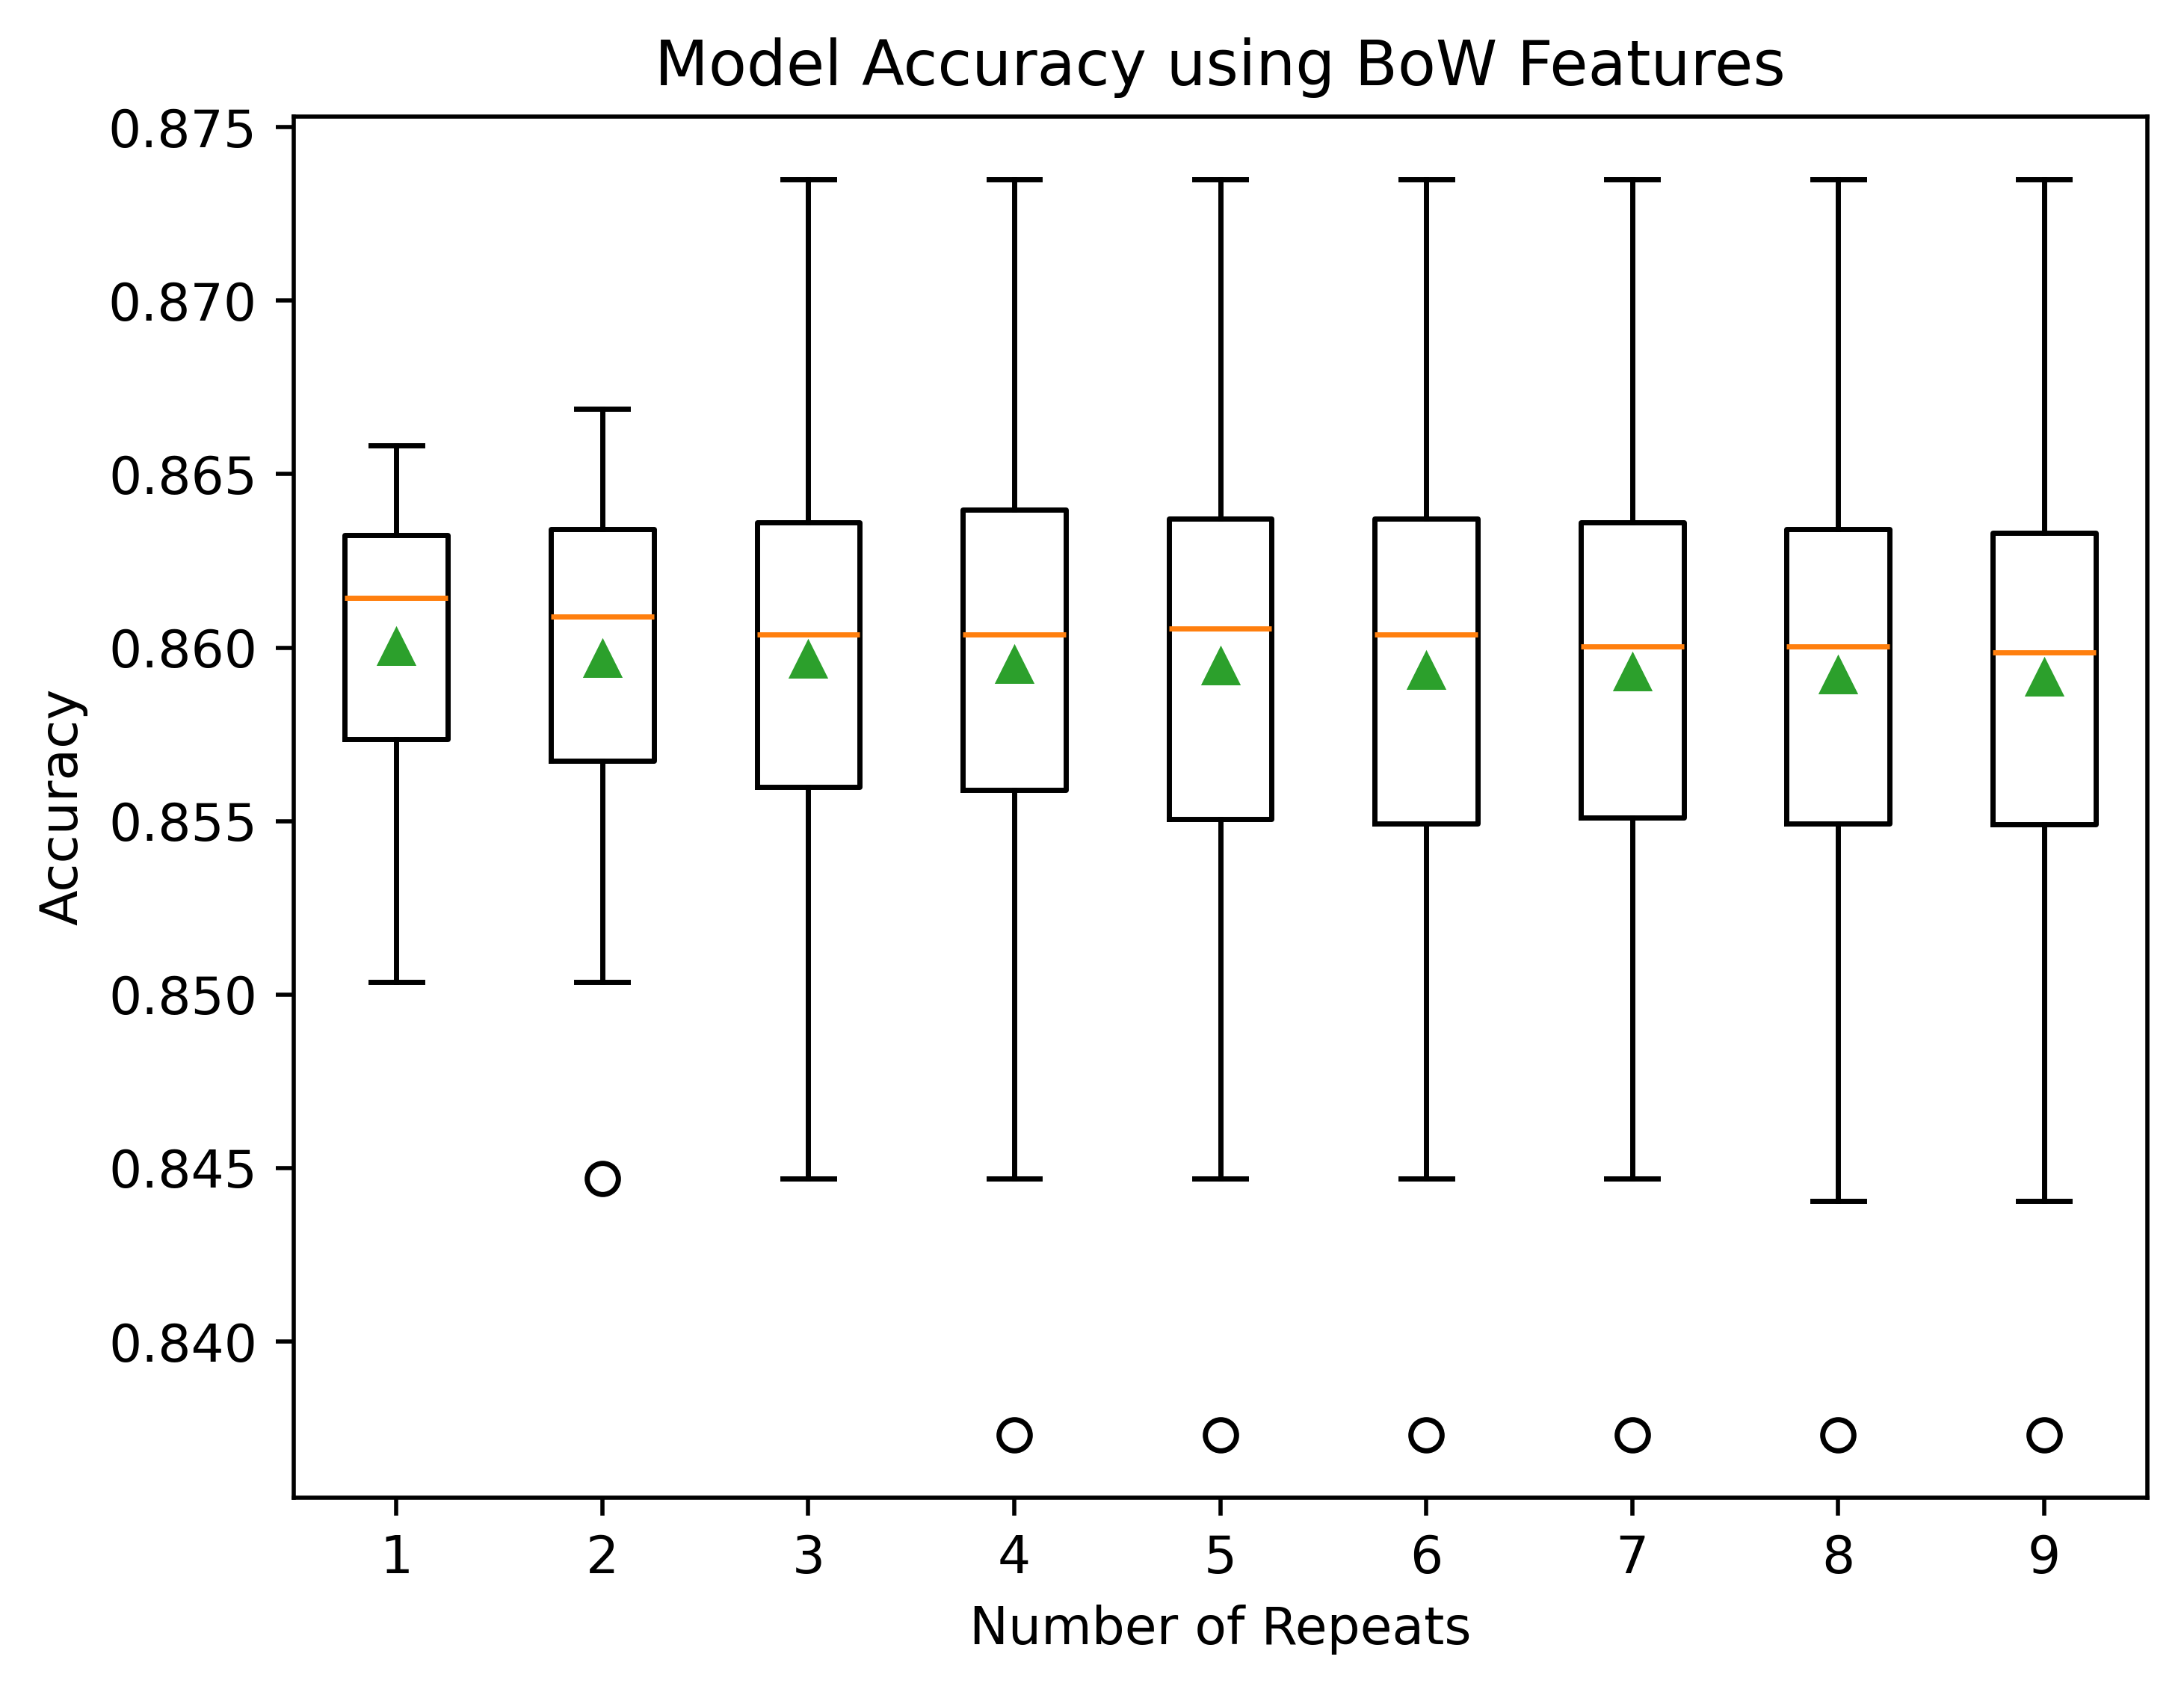

In [22]:
results = list()

for r in repeats:
	# evaluate using a given number of repeats
	scores = evaluate_model(X_bow_combined, y, r)
	# summarize
	print('>%d mean=%.8f se=%.3f' % (r, np.mean(scores), sem(scores)))
	# store
	results.append(scores)

# Plot the results of the evaluations
plt.boxplot(results, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "xgb_bow"
dataset = "Full"
results = pd.DataFrame(results)
results.to_csv(f'k-fold_results/{dataset}/{model}.csv', index=False)

## **Hyperparameter Tuning**

In [ ]:
def perform_hyperparameter_tuning(model, X_train, y_train, param_dist, search_type='grid', n_iter=None):
    start_time = time.time()
    
    if search_type == 'grid':
        search = GridSearchCV(estimator=model, param_grid=param_dist, cv=10, n_jobs=-1, verbose=True, scoring='accuracy')
    else:  # Randomized search
        search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=n_iter, cv=10, n_jobs=-1, verbose=True, scoring='accuracy')
    
    search.fit(X_train, y_train)
    duration = time.time() - start_time
    
    print(f"Best Parameters: {search.best_params_}\n")
    print(f"Best Score: {search.best_score_}\n")
    print(f"Time Taken: {duration:.2f} seconds")
    
    return search.best_params_, search.best_score_, duration

# Assuming X_train_bow and y_train_bow are predefined
# Define the model and parameter grid
xgb_model = XGBClassifier(n_estimators=3000, random_state=40)
param_grid = {
    'learning_rate': [0.2, 0.3, 0.4],
    'max_depth': [3, 5, 10],
    'gamma': [0.1, 0.2, 0.3],
    'reg_alpha': [0.001, 0.01, 0.1]
}

metrics = []

# Perform Randomized Search
# {'reg_alpha': 0.001, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0.1}
print("Performing Randomized Search...")
random_metrics = perform_hyperparameter_tuning(xgb_model, X_train_bow, y_train_bow, param_grid, search_type='random', n_iter=300)
metrics.append(('Randomized Search', *random_metrics))

# Perform Grid Search
# {'gamma': 0.1, 'learning_rate': 0.2, 'max_depth': 10, 'reg_alpha': 0.001}
print("Performing Grid Search...")
grid_metrics = perform_hyperparameter_tuning(xgb_model, X_train_bow, y_train_bow, param_grid, search_type='grid')
metrics.append(('Grid Search', *grid_metrics))

# Display metrics table
metrics_df = pd.DataFrame(metrics, columns=['Search Type', 'Best Parameters', 'Best Score', 'Time Taken (s)'])
print(metrics_df)

In [66]:
metrics_df

,Search Type,Best Parameters,Best Score,Time Taken (s)
0,Randomized Search,"{'reg_alpha': 0.001, 'max_depth': 10, 'learnin...",0.905135,5607.401938
1,Grid Search,"{'gamma': 0.1, 'learning_rate': 0.2, 'max_dept...",0.905135,5506.570848


### Best Model

In [69]:
best_xgb_model = XGBClassifier(n_estimators=3000, random_state=40, learning_rate=0.2, max_depth=10, gamma=0.1, reg_alpha=0.001)

# Train the model using the BoW vectorized data
best_xgb_model.fit(X_train_bow, y_train_bow)

# Predict the labels for the test data
y_pred = best_xgb_model.predict(X_test_bow)

# Calculate the accuracy
accuracy = accuracy_score(y_test_bow, y_pred)

# Generate the classification report
report = classification_report(y_test_bow, y_pred)

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test_bow, y_pred)

print("Best XGBoost Model (BoW):")
print("Accuracy:", accuracy, "\n")
print("Classification Report:")
print(report, "\n")
print("Confusion Matrix:")
print(conf_matrix)

Best XGBoost Model (BoW):
Accuracy: 0.9081861159492411 

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.72      0.75       898
           1       0.92      0.95      0.93      4666
           2       0.93      0.90      0.91      2474

    accuracy                           0.91      8038
   macro avg       0.88      0.86      0.87      8038
weighted avg       0.91      0.91      0.91      8038
 

Confusion Matrix:
[[ 645  198   55]
 [ 121 4429  116]
 [  45  203 2226]]
